# Zero-Shot CLIP Inference with OpenVINO

This notebook performs image and text-based search using zero-shot CLIP model optimized with OpenVINO.
Uses **cosine similarity** for all search operations on the fashion dataset.

In [1]:
import os
import numpy as np
import pickle
from pathlib import Path
from PIL import Image
import torch
import clip
from openvino.runtime import Core
import faiss
import matplotlib.pyplot as plt

## Configuration

In [2]:
MODEL_DIR = Path(r"e:\Projects\AI Based\RecTrio\V1\models")
VECTOR_DB_DIR = Path(r"e:\Projects\AI Based\RecTrio\V1\vector_db")  # Updated to use pruned dataset
DATASET_PATH = Path(r"e:\Projects\AI Based\RecTrio\datasets\fashion")

# Create directories if they don't exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
VECTOR_DB_DIR.mkdir(parents=True, exist_ok=True)

CLIP_MODEL_NAME = "ViT-B/32"  # Fast GitHub CLIP model
VISION_MODEL_PATH = MODEL_DIR / "clip_vision_model.xml"
TEXT_MODEL_PATH = MODEL_DIR / "clip_text_model.xml"
FAISS_INDEX_PATH = VECTOR_DB_DIR / "faiss_index.bin"
METADATA_PATH = VECTOR_DB_DIR / "metadata.pkl"

TOP_K = 10

# Image Display Configuration
UPSCALE_IMAGES = True       # Enable automatic upscaling of small images
MIN_DISPLAY_SIZE = 250      # Minimum size in pixels for upscaling (default: 250)
MAX_DISPLAY_SIZE = 600      # Maximum size limit to prevent excessive upscaling

print(f"✓ Dataset: Fashion Dataset (Pruned)")
print(f"✓ Dataset path: {DATASET_PATH}")
print(f"✓ Model directory: {MODEL_DIR}")
print(f"✓ Vector DB directory: {VECTOR_DB_DIR}")
print(f"✓ Similarity metric: Cosine Similarity")
print(f"✓ Image upscaling: {'Enabled' if UPSCALE_IMAGES else 'Disabled'} (min: {MIN_DISPLAY_SIZE}px, max: {MAX_DISPLAY_SIZE}px)")

✓ Dataset: Fashion Dataset (Pruned)
✓ Dataset path: e:\Projects\AI Based\RecTrio\datasets\fashion
✓ Model directory: e:\Projects\AI Based\RecTrio\V1\models
✓ Vector DB directory: e:\Projects\AI Based\RecTrio\V1\vector_db
✓ Similarity metric: Cosine Similarity
✓ Image upscaling: Enabled (min: 250px, max: 600px)


## Load Processor and Model Components

In [3]:
print("Loading CLIP model (fast GitHub version)...")
model, preprocess = clip.load(CLIP_MODEL_NAME, device="cpu")
model.eval()
print(f"✓ CLIP {CLIP_MODEL_NAME} loaded successfully (in ~2-3 seconds!)")

Loading CLIP model (fast GitHub version)...
✓ CLIP ViT-B/32 loaded successfully (in ~2-3 seconds!)
✓ CLIP ViT-B/32 loaded successfully (in ~2-3 seconds!)


## Load OpenVINO Models

In [4]:
core = Core()

print("Loading vision model...")
vision_compiled_model = core.compile_model(str(VISION_MODEL_PATH), "CPU")
vision_input_layer = vision_compiled_model.input(0)
vision_output_layer = vision_compiled_model.output(0)

print("Loading text model...")
text_compiled_model = core.compile_model(str(TEXT_MODEL_PATH), "CPU")
text_output_layer = text_compiled_model.output(0)

print("OpenVINO models loaded on CPU")

Loading vision model...
Loading text model...
Loading text model...
OpenVINO models loaded on CPU
OpenVINO models loaded on CPU


## Load FAISS Index and Metadata

In [5]:
print("Loading FAISS index...")
index = faiss.read_index(str(FAISS_INDEX_PATH))
print(f"✓ Loaded index with {index.ntotal} vectors")
print(f"✓ Index type: {type(index).__name__}")
print(f"✓ Using cosine similarity (IndexFlatIP with normalized vectors)")

print("\nLoading metadata...")
with open(METADATA_PATH, 'rb') as f:
    metadata = pickle.load(f)

image_paths = metadata['image_paths']
print(f"✓ Loaded {len(image_paths)} image paths")

Loading FAISS index...
✓ Loaded index with 32356 vectors
✓ Index type: IndexFlatIP
✓ Using cosine similarity (IndexFlatIP with normalized vectors)

Loading metadata...
✓ Loaded 32356 image paths


## Embedding Functions

In [6]:
def get_image_embedding(image_input):
    """Generate image embedding using OpenVINO vision model"""
    if isinstance(image_input, str):
        image = Image.open(image_input).convert('RGB')
    else:
        image = image_input.convert('RGB')
    
    image_tensor = preprocess(image).unsqueeze(0)
    pixel_values = image_tensor.numpy()
    
    # Run inference with OpenVINO
    result = vision_compiled_model([pixel_values])[vision_output_layer]
    
    # Get embedding and normalize
    embedding = result[0]
    embedding = embedding / np.linalg.norm(embedding)
    
    return embedding.astype('float32')

def get_text_embedding(text):
    """Generate text embedding using OpenVINO text model"""
    # Use CLIP's tokenization
    text_tokens = clip.tokenize([text])
    
    # Run inference with OpenVINO
    result = text_compiled_model([text_tokens.numpy()])[text_output_layer]
    
    # Get embedding and normalize
    embedding = result[0]
    embedding = embedding / np.linalg.norm(embedding)
    
    return embedding.astype('float32')

## Search Function

In [7]:
def search_similar_images(query_embedding, top_k=TOP_K):
    """
    Search for similar images using cosine similarity.
    Since embeddings are L2-normalized and we use IndexFlatIP,
    the inner product equals cosine similarity.
    """
    query_embedding = query_embedding.reshape(1, -1)
    
    # FAISS search returns cosine similarity scores (higher = more similar)
    distances, indices = index.search(query_embedding, top_k)
    
    results = []
    for idx, dist in zip(indices[0], distances[0]):
        results.append({
            'path': image_paths[idx],
            'similarity': float(dist)  # Cosine similarity score
        })
    
    return results

## Image Upscaling Function

Use LANCZOS resampling for high-quality image upscaling without losing details.

In [8]:
def upscale_image(image, min_size=300, max_size=800):
    """
    Upscale small images while maintaining quality using LANCZOS resampling.
    
    Args:
        image: PIL Image object
        min_size: Minimum dimension size (will upscale if smaller)
        max_size: Maximum dimension size (won't upscale beyond this)
        
    Returns:
        Upscaled PIL Image
    """
    width, height = image.size
    min_dim = min(width, height)
    max_dim = max(width, height)
    
    # If image is already large enough, return as-is
    if min_dim >= min_size:
        return image
    
    # Calculate scale factor to reach minimum size
    scale_factor = min_size / min_dim
    
    # Don't upscale beyond max_size
    if max_dim * scale_factor > max_size:
        scale_factor = max_size / max_dim
    
    # Calculate new dimensions
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    
    # Use LANCZOS for high-quality upscaling
    upscaled = image.resize((new_width, new_height), Image.LANCZOS)
    
    return upscaled

print("✓ Image upscaling function defined (LANCZOS resampling for quality)")

✓ Image upscaling function defined (LANCZOS resampling for quality)


## Visualization Function

In [9]:
def display_results(results, query_info=None, upscale=True, min_display_size=250):
    """
    Display search results with optional image upscaling.
    
    Args:
        results: List of search results
        query_info: Optional query description
        upscale: Whether to upscale small images (default: True)
        min_display_size: Minimum size for upscaling (default: 250px)
    """
    # Filter out missing images
    valid_results = []
    for result in results:
        if os.path.exists(result['path']):
            valid_results.append(result)
        else:
            # Try alternative path (remove V1 from path if present)
            alt_path = result['path'].replace(r"\V1\datasets", r"\datasets")
            if os.path.exists(alt_path):
                result['path'] = alt_path
                valid_results.append(result)
            else:
                print(f"⚠ Skipping missing image: {result['path']}")
    
    if not valid_results:
        print("No valid images found in results!")
        return
    
    n_results = len(valid_results)
    cols = 5
    rows = (n_results + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5 * rows))
    axes = axes.flatten() if n_results > 1 else [axes]
    
    for idx, result in enumerate(valid_results):
        img = Image.open(result['path'])
        
        # Upscale small images for better visibility
        if upscale:
            img = upscale_image(img, min_size=min_display_size, max_size=600)
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        # Show category and similarity
        category = Path(result['path']).parent.name
        title = f"{category}\nSim: {result['similarity']:.3f}"
        axes[idx].set_title(title, fontsize=9, fontweight='bold')
    
    for idx in range(n_results, len(axes)):
        axes[idx].axis('off')
    
    if query_info:
        fig.suptitle(f"Query: {query_info}", fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization function defined (with automatic image upscaling)")

✓ Visualization function defined (with automatic image upscaling)


## Image-Based Search

Searching for images similar to: e:\Projects\AI Based\RecTrio\datasets\fashion\Backpacks\10774.jpg

Top 10 similar images (Cosine Similarity):
1. Category: Backpacks | Similarity: 1.0000
2. Category: Backpacks | Similarity: 0.9539
3. Category: Backpacks | Similarity: 0.9532
4. Category: Backpacks | Similarity: 0.9523
5. Category: Backpacks | Similarity: 0.9502
6. Category: Backpacks | Similarity: 0.9494
7. Category: Backpacks | Similarity: 0.9488
8. Category: Backpacks | Similarity: 0.9416
9. Category: Backpacks | Similarity: 0.9408
10. Category: Backpacks | Similarity: 0.9390


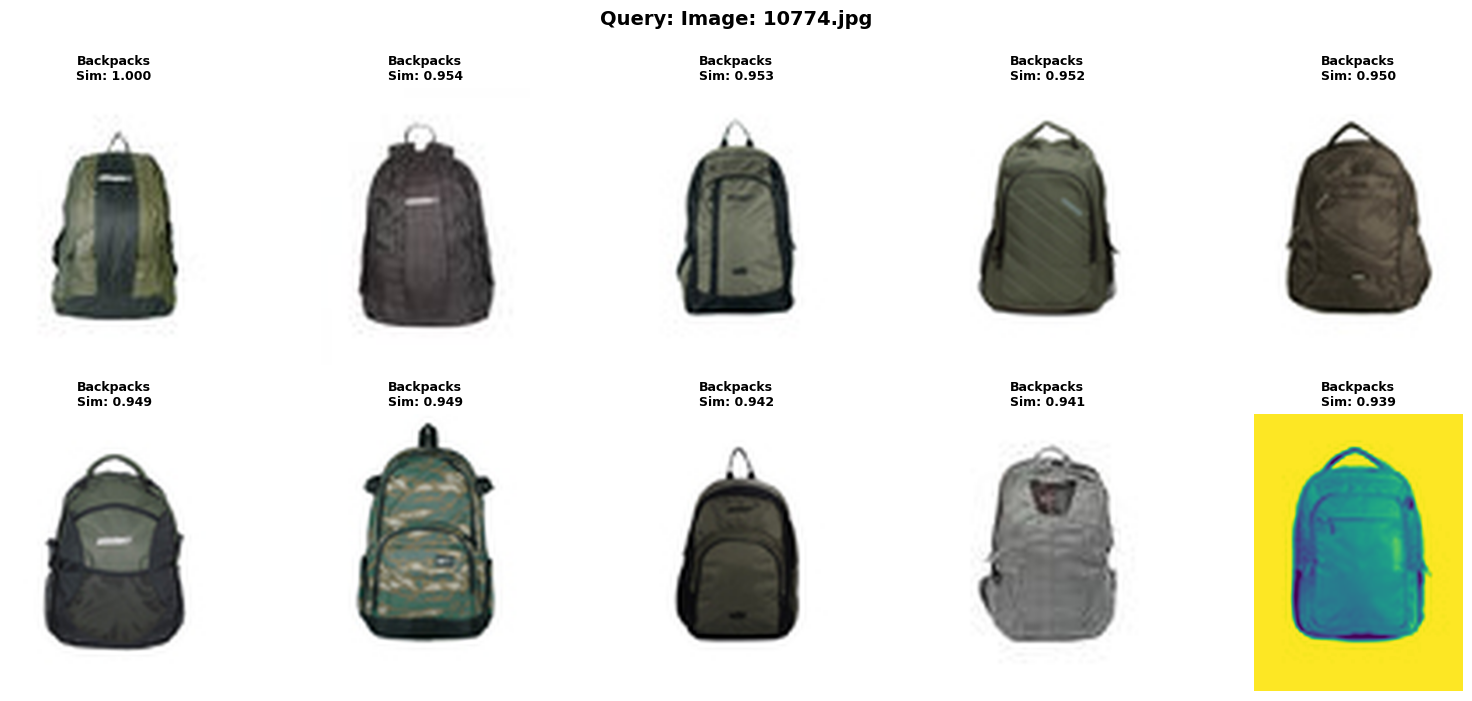

In [10]:
# Get a sample fashion image from the dataset
import random

# Find first available category folder
category_folders = [d for d in DATASET_PATH.iterdir() if d.is_dir()]
if category_folders:
    sample_category = category_folders[0]
    image_files = list(sample_category.glob("*.jpg"))[:1]
    if image_files:
        query_image_path = str(image_files[0])
    else:
        query_image_path = None
else:
    query_image_path = None

if query_image_path:
    print(f"Searching for images similar to: {query_image_path}")
    query_embedding = get_image_embedding(query_image_path)
    results = search_similar_images(query_embedding)

    print(f"\nTop {len(results)} similar images (Cosine Similarity):")
    for i, result in enumerate(results, 1):
        category = Path(result['path']).parent.name
        print(f"{i}. Category: {category} | Similarity: {result['similarity']:.4f}")

    display_results(results, query_info=f"Image: {Path(query_image_path).name}", 
                   upscale=UPSCALE_IMAGES, min_display_size=MIN_DISPLAY_SIZE)
else:
    print("No sample images found in fashion dataset!")

## Text-Based Search

Searching for: 'a photo of a tshirt'

Top 10 similar images (Cosine Similarity):
1. Category: Tshirts | Similarity: 0.2923
2. Category: Tshirts | Similarity: 0.2910
3. Category: Tshirts | Similarity: 0.2878
4. Category: Tshirts | Similarity: 0.2877
5. Category: Tshirts | Similarity: 0.2871
6. Category: Tshirts | Similarity: 0.2862
7. Category: Tshirts | Similarity: 0.2856
8. Category: Tshirts | Similarity: 0.2849
9. Category: Tshirts | Similarity: 0.2841
10. Category: Tshirts | Similarity: 0.2839


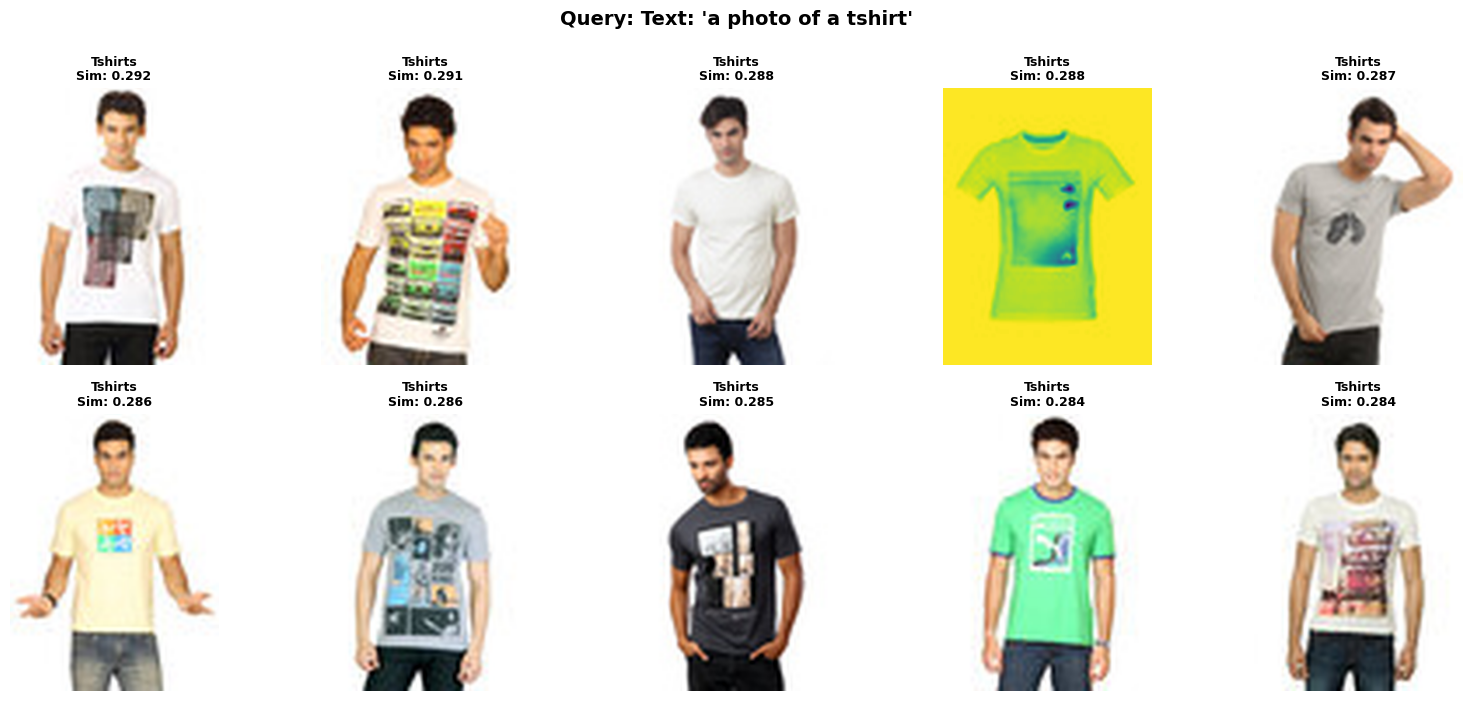

In [11]:
query_text = "a photo of a tshirt"

print(f"Searching for: '{query_text}'")
query_embedding = get_text_embedding(query_text)
results = search_similar_images(query_embedding)

print(f"\nTop {len(results)} similar images (Cosine Similarity):")
for i, result in enumerate(results, 1):
    category = Path(result['path']).parent.name
    print(f"{i}. Category: {category} | Similarity: {result['similarity']:.4f}")

display_results(results, query_info=f"Text: '{query_text}'", 
               upscale=UPSCALE_IMAGES, min_display_size=MIN_DISPLAY_SIZE)

## Interactive Search

In [12]:
# def interactive_search():
#     print("Choose search type:")
#     print("1. Image search")
#     print("2. Text search")
    
#     choice = input("Enter choice (1-image or 2-text): ").strip()
    
#     if choice == "1":
#         image_path = input("Enter image path: ").strip()
#         if not os.path.exists(image_path):
#             print("Image not found!")
#             return
        
#         print(f"\nSearching for images similar to: {image_path}")
#         query_embedding = get_image_embedding(image_path)
#         results = search_similar_images(query_embedding)
        
#         print(f"\nTop {len(results)} similar images:")
#         for i, result in enumerate(results, 1):
#             print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")
        
#         display_results(results, query_info=f"Image: {Path(image_path).name}")
        
#     elif choice == "2":
#         text_query = input("Enter search text: ").strip()
        
#         print(f"\nSearching for: '{text_query}'")
#         query_embedding = get_text_embedding(text_query)
#         results = search_similar_images(query_embedding)
        
#         print(f"\nTop {len(results)} similar images:")
#         for i, result in enumerate(results, 1):
#             print(f"{i}. {result['path']} (Similarity: {result['similarity']:.4f})")
        
#         display_results(results, query_info=f"Text: '{text_query}'")
#     else:
#         print("Invalid choice!")

# interactive_search()

In [13]:
import json

# Load the fashion knowledge graph
KG_PATH = Path(r"e:\Projects\AI Based\RecTrio\V1\vector_db\fashion_knowledge_graph.json")

with open(KG_PATH, 'r') as f:
    knowledge_graph = json.load(f)

print("✓ Fashion knowledge graph loaded successfully")
print(f"✓ Entities in knowledge graph: {len(knowledge_graph['entities'])}")
print(f"✓ Sample entities: {list(knowledge_graph['entities'].keys())[:10]}")
print(f"✓ Using cosine similarity for all search operations")

✓ Fashion knowledge graph loaded successfully
✓ Entities in knowledge graph: 30
✓ Sample entities: ['Tshirts', 'Shirts', 'Jeans', 'Trousers', 'Casual_Shoes', 'Formal_Shoes', 'Sports_Shoes', 'Heels', 'Sandals', 'Flip_Flops']
✓ Using cosine similarity for all search operations


In [14]:
def find_entity_from_path(image_path):
    """Extract entity name (fashion category) from image path"""
    path_parts = Path(image_path).parts
    # Find the fashion category from the path
    for part in path_parts:
        part_normalized = part.replace('_', ' ').replace('-', ' ').strip()
        # Check exact match first
        if part in knowledge_graph['entities']:
            return part
        # Check normalized match
        for entity in knowledge_graph['entities'].keys():
            if entity.lower() == part.lower() or entity.replace('_', ' ').lower() == part_normalized.lower():
                return entity
    return None

def get_related_entities(entity_name, max_related=10):
    """
    Get related entities from the knowledge graph with their relationship strengths
    
    Returns:
        List of tuples: [(entity_name, strength), ...]
        Sorted by strength (highest first)
    """
    if entity_name not in knowledge_graph['entities']:
        return []
    
    entity_info = knowledge_graph['entities'][entity_name]
    related = entity_info.get('related_entities', {})
    
    # Convert dict to list of tuples and sort by strength
    related_list = [(entity, strength) for entity, strength in related.items()]
    related_list.sort(key=lambda x: -x[1])  # Sort by strength descending
    
    return related_list[:max_related]

def add_entity_relationship(entity1, entity2, strength=0.5):
    """
    Add a relationship between two entities with a strength metric (bidirectional)
    This allows dynamic updates based on user searches
    
    Args:
        entity1: First entity name
        entity2: Second entity name
        strength: Relationship strength (0.0 to 1.0)
    """
    if entity1 not in knowledge_graph['entities']:
        knowledge_graph['entities'][entity1] = {'related_entities': {}}
    
    if entity2 not in knowledge_graph['entities']:
        knowledge_graph['entities'][entity2] = {'related_entities': {}}
    
    # Add bidirectional relationship with strength
    knowledge_graph['entities'][entity1]['related_entities'][entity2] = strength
    knowledge_graph['entities'][entity2]['related_entities'][entity1] = strength
    
    print(f"✓ Added relationship: {entity1} ↔ {entity2} (strength: {strength:.2f})")

def update_relationship_strength(entity1, entity2, new_strength):
    """
    Update the strength of an existing relationship
    
    Args:
        entity1: First entity name
        entity2: Second entity name
        new_strength: New relationship strength (0.0 to 1.0)
    """
    if entity1 in knowledge_graph['entities'] and entity2 in knowledge_graph['entities']['related_entities']:
        knowledge_graph['entities'][entity1]['related_entities'][entity2] = new_strength
        knowledge_graph['entities'][entity2]['related_entities'][entity1] = new_strength
        print(f"✓ Updated relationship strength: {entity1} ↔ {entity2} → {new_strength:.2f}")
    else:
        print(f"⚠ Relationship not found: {entity1} ↔ {entity2}")

def save_knowledge_graph():
    """Save the updated knowledge graph to disk"""
    import json
    with open(KG_PATH, 'w') as f:
        json.dump(knowledge_graph, f, indent=2)
    print("✓ Knowledge graph saved")

print("✓ Fashion knowledge graph helper functions defined")
print("✓ All searches use cosine similarity (relationship strength weighting)")

✓ Fashion knowledge graph helper functions defined
✓ All searches use cosine similarity (relationship strength weighting)


In [15]:
def kg_based_recommendation(query_input, input_type='image', top_k=10, use_semantic_expansion=False):
    """
    Get recommendations using knowledge graph with relationship strength weighting
    Returns ONLY images from RELATED classes (excludes query class)
    
    Args:
        query_input: Image path or text query
        input_type: 'image' or 'text'
        top_k: Number of recommendations to return
        use_semantic_expansion: Deprecated (kept for compatibility)
    
    Returns:
        Dictionary with entity info and recommendations
    """
    results = {
        'query_entity': None,
        'related_entities': [],
        'recommendations': []
    }
    
    # Step 1: Get initial query embedding and find entity
    if input_type == 'image':
        query_embedding = get_image_embedding(query_input)
        # Extract entity from image path
        query_entity = find_entity_from_path(query_input)
    else:  # text
        query_embedding = get_text_embedding(query_input)
        # Try to find entity in the query text (improved matching)
        query_entity = None
        query_lower = query_input.lower()
        
        # First try exact match (case-insensitive)
        for entity in knowledge_graph['entities'].keys():
            if entity.lower() in query_lower or entity.replace('_', ' ').lower() in query_lower:
                query_entity = entity
                break
        
        # If not found, try matching without underscores/spaces
        if not query_entity:
            query_clean = query_lower.replace(' ', '').replace('_', '')
            for entity in knowledge_graph['entities'].keys():
                entity_clean = entity.lower().replace(' ', '').replace('_', '')
                if entity_clean in query_clean or query_clean in entity_clean:
                    query_entity = entity
                    break
        
        # If still not found, try singular/plural variations
        if not query_entity:
            # Try adding/removing 's' at the end
            for entity in knowledge_graph['entities'].keys():
                entity_lower = entity.lower()
                # Check if query is plural of entity or vice versa
                if (query_lower.rstrip('s') == entity_lower.rstrip('s') or
                    query_lower + 's' == entity_lower or
                    query_lower == entity_lower + 's'):
                    query_entity = entity
                    break
    
    if not query_entity:
        print("⚠ Could not identify entity from query. Using direct search...")
        # Fall back to direct search - but still return proper structure
        initial_results = search_similar_images(query_embedding, top_k)
        # Try to get entity from top result
        if initial_results:
            query_entity = find_entity_from_path(initial_results[0]['path'])
            results['query_entity'] = query_entity
            print(f"📍 Detected entity from top result: {query_entity}")
            
            # Now proceed with KG recommendations using detected entity
            if query_entity and query_entity in knowledge_graph['entities']:
                related_entities_with_strength = get_related_entities(query_entity, max_related=10)
                related_entities = [entity for entity, _ in related_entities_with_strength]
                results['related_entities'] = related_entities
                
                print(f"Related entities with strengths:")
                for entity, strength in related_entities_with_strength:
                    print(f"   - {entity}: {strength:.2f}")
            else:
                results['recommendations'] = initial_results
                return results
        else:
            results['recommendations'] = initial_results
            return results
    else:
        results['query_entity'] = query_entity
        print(f"Query entity: {query_entity}")
        
        # Step 2: Get related entities with strength scores from knowledge graph
        related_entities_with_strength = get_related_entities(query_entity, max_related=10)
        related_entities = [entity for entity, _ in related_entities_with_strength]
        results['related_entities'] = related_entities
        
        print(f"Related entities with strengths:")
        for entity, strength in related_entities_with_strength:
            print(f"   - {entity}: {strength:.2f}")
    
    # Step 3: Use only related entities (exclude query entity)
    search_labels = related_entities_with_strength.copy()
    
    if not search_labels:
        print("⚠ No related entities found in knowledge graph")
        return results
    
    # Step 4: Generate embeddings for related labels and search
    all_recommendations = []
    seen_paths = set()
    
    for label, relationship_strength in search_labels:
        # Create a descriptive text query
        text_query = f"a photo of a {label.replace('_', ' ')}"
        label_embedding = get_text_embedding(text_query)
        
        # Search for similar images
        label_results = search_similar_images(label_embedding, top_k=15)
        
        # Add to recommendations with label info and weighted score
        for result in label_results:
            # Get entity from path
            result_entity = find_entity_from_path(result['path'])
            
            # SKIP if it's the same class as query
            if result_entity == query_entity:
                continue
            
            # SKIP if it's not from the target label category
            # This ensures we only get items from the related category we're searching for
            if result_entity != label:
                continue
            
            # Add only if not seen and from different class
            if result['path'] not in seen_paths:
                # Weight the similarity by relationship strength
                weighted_similarity = result['similarity'] * relationship_strength
                
                result['matched_label'] = label
                result['result_entity'] = result_entity
                result['is_primary'] = False  # All are related entities
                result['relationship_strength'] = relationship_strength
                result['original_similarity'] = result['similarity']
                result['weighted_similarity'] = weighted_similarity
                result['similarity'] = weighted_similarity 
                
                all_recommendations.append(result)
                seen_paths.add(result['path'])
    
    # Step 5: Sort by weighted similarity and limit to top_k
    all_recommendations.sort(key=lambda x: -x['weighted_similarity'])
    results['recommendations'] = all_recommendations[:top_k]
    
    print(f"✓ Found {len(results['recommendations'])} recommendations from related classes")
    
    return results

print("✓ Knowledge graph-based recommendation function defined (with relationship strength weighting)")

✓ Knowledge graph-based recommendation function defined (with relationship strength weighting)


In [16]:
def display_kg_recommendations(kg_results, query_info=None, upscale=True, min_display_size=250):
    """
    Display knowledge graph-based recommendations with entity and relationship strength information.
    
    Args:
        kg_results: Results dictionary from kg_based_recommendation()
        query_info: Optional query description
        upscale: Whether to upscale small images (default: True)
        min_display_size: Minimum size for upscaling (default: 250px)
    """
    recommendations = kg_results['recommendations']
    query_entity = kg_results['query_entity']
    related_entities = kg_results['related_entities']
    
    if not recommendations:
        print("No recommendations found!")
        return
    
    # Filter out missing images and fix paths
    valid_recommendations = []
    for result in recommendations:
        if os.path.exists(result['path']):
            valid_recommendations.append(result)
        else:
            # Try alternative path (remove V1 from path if present)
            alt_path = result['path'].replace(r"\V1\datasets", r"\datasets")
            if os.path.exists(alt_path):
                result['path'] = alt_path
                valid_recommendations.append(result)
            else:
                print(f"⚠ Skipping missing image: {result['path']}")
    
    if not valid_recommendations:
        print("No valid images found in recommendations!")
        return
    
    n_results = len(valid_recommendations)
    cols = 5
    rows = (n_results + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5 * rows))
    axes = axes.flatten() if n_results > 1 else [axes]
    
    for idx, result in enumerate(valid_recommendations):
        img = Image.open(result['path'])
        
        # Upscale small images for better visibility
        if upscale:
            img = upscale_image(img, min_size=min_display_size, max_size=600)
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        # Add label information with relationship strength
        label = result.get('matched_label', 'unknown')
        weighted_sim = result.get('weighted_similarity', result['similarity'])
        original_sim = result.get('original_similarity', result['similarity'])
        rel_strength = result.get('relationship_strength', 0)
        is_primary = result.get('is_primary', False)
        
        # Choose color based on relationship strength
        if rel_strength >= 0.8:
            title_color = 'darkgreen'
        elif rel_strength >= 0.6:
            title_color = 'green'
        elif rel_strength >= 0.4:
            title_color = 'orange'
        else:
            title_color = 'blue'
        
        # Show weighted similarity and relationship strength
        title = f"{label}\n"
        title += f"Sim: {weighted_sim:.3f}\n"
        title += f"Rel: {rel_strength:.2f}"
        
        axes[idx].set_title(
            title, 
            fontsize=9,
            color=title_color,
            fontweight='bold' if rel_strength >= 0.7 else 'normal'
        )
    
    for idx in range(n_results, len(axes)):
        axes[idx].axis('off')
    
    # Add title with entity information
    title = f"Query Entity: {query_entity}"
    if related_entities:
        title += f"\nRelated: {', '.join(related_entities)}"
    if query_info:
        title = f"{query_info}\n{title}"
    
    fig.suptitle(title, fontsize=14, y=0.995)
    
    plt.tight_layout()
    plt.show()

print("✓ KG visualization function defined (with relationship strength display)")

✓ KG visualization function defined (with relationship strength display)


Querying with image from category: Backpacks -> 10774.jpg

Query entity: Backpacks
Related entities with strengths:
   - Casual_Shoes: 0.85
   - Tshirts: 0.80
   - Jeans: 0.75
   - Watches: 0.65
   - Caps: 0.60
   - Sunglasses: 0.55
   - Jackets: 0.50
   - Handbags: 0.30
✓ Found 10 recommendations from related classes

Total recommendations: 10

Top 5 recommendations (Cosine Similarity):
   1. Casual_Shoes - Similarity: 0.2450 (Rel: 0.85)
   2. Casual_Shoes - Similarity: 0.2445 (Rel: 0.85)
   3. Casual_Shoes - Similarity: 0.2435 (Rel: 0.85)
   4. Casual_Shoes - Similarity: 0.2427 (Rel: 0.85)
   5. Casual_Shoes - Similarity: 0.2427 (Rel: 0.85)
✓ Found 10 recommendations from related classes

Total recommendations: 10

Top 5 recommendations (Cosine Similarity):
   1. Casual_Shoes - Similarity: 0.2450 (Rel: 0.85)
   2. Casual_Shoes - Similarity: 0.2445 (Rel: 0.85)
   3. Casual_Shoes - Similarity: 0.2435 (Rel: 0.85)
   4. Casual_Shoes - Similarity: 0.2427 (Rel: 0.85)
   5. Casual_Shoes - S

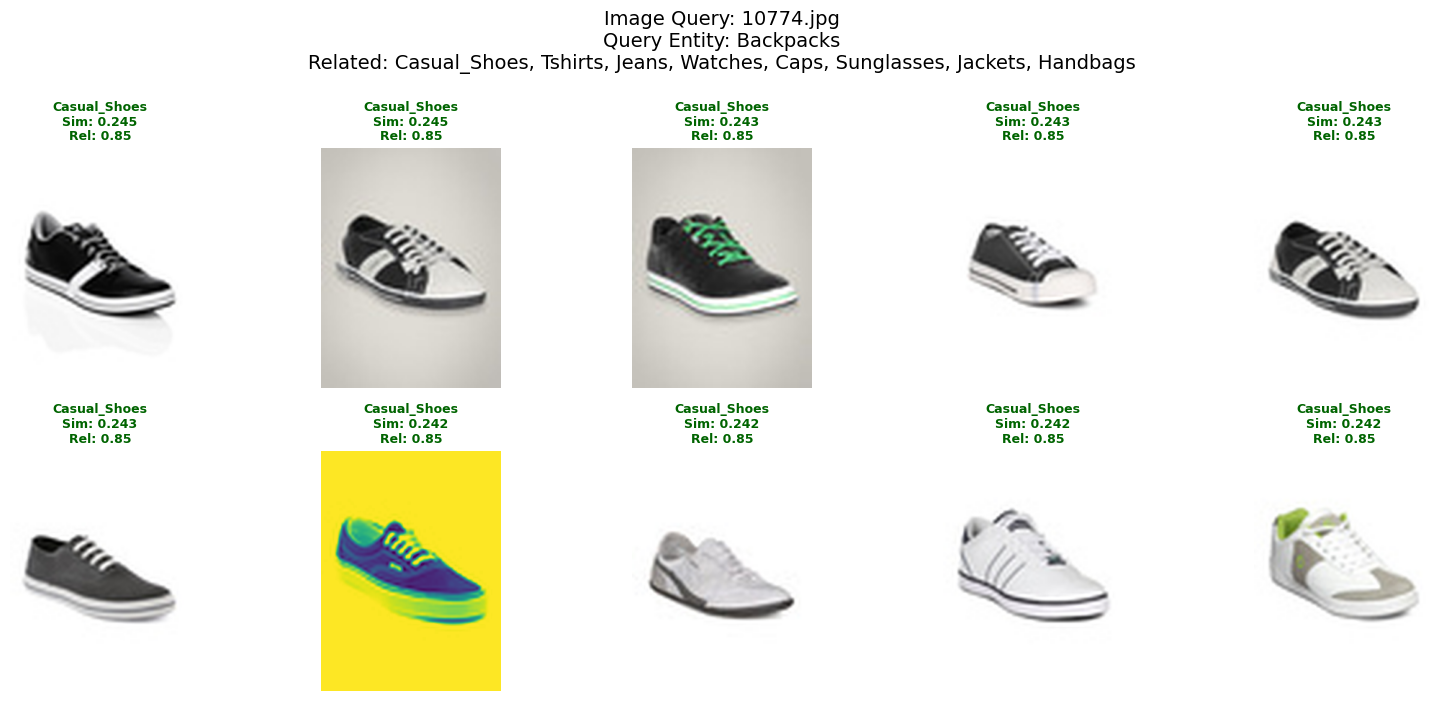

In [17]:
# Example with a fashion image (dynamic category from knowledge graph)
# Pick the first existing category that is allowed by the KG
from pathlib import Path
import json

# Ensure DATASET_PATH and knowledge_graph are already defined by previous cells
# Build allowed category list from the knowledge graph
allowed_categories = set(knowledge_graph['entities'].keys())
for ent, info in knowledge_graph['entities'].items():
    allowed_categories.update((info or {}).get('related_entities', {}).keys())

allowed_categories = sorted(allowed_categories)

# Choose the first allowed category that exists in the dataset
sample_path = None
chosen_category = None
for cat in allowed_categories:
    folder = DATASET_PATH / cat
    if folder.exists() and any(folder.glob("*.jpg")):
        chosen_category = cat
        images = list(folder.glob("*.jpg"))[:1]
        if images:
            sample_path = str(images[0])
            break

# Fallback: pick first available category if none matched (shouldn't happen after pruning)
if not sample_path:
    category_folders = [d for d in DATASET_PATH.iterdir() if d.is_dir()]
    if category_folders:
        sample_category = category_folders[0]
        image_files = list(sample_category.glob("*.jpg"))[:1]
        if image_files:
            sample_path = str(image_files[0])
            chosen_category = sample_category.name

if sample_path:
    query_image_path = sample_path
    print(f"Querying with image from category: {chosen_category} -> {Path(query_image_path).name}\n")

    # Get recommendations using knowledge graph
    kg_results = kg_based_recommendation(
        query_input=query_image_path,
        input_type='image',
        top_k=10,
        use_semantic_expansion=True
    )

    print(f"\nTotal recommendations: {len(kg_results['recommendations'])}")
    print("\nTop 5 recommendations (Cosine Similarity):")
    for i, result in enumerate(kg_results['recommendations'][:5], 1):
        entity = result.get('matched_label', 'unknown')
        sim = result.get('weighted_similarity', result.get('similarity', 0))
        rel_strength = result.get('relationship_strength', 0)
        is_primary = result.get('is_primary', False)
        marker = "⭐" if is_primary else "  "
        print(f"{marker} {i}. {entity} - Similarity: {sim:.4f} (Rel: {rel_strength:.2f})")

    # Display the results
    display_kg_recommendations(kg_results, query_info=f"Image Query: {Path(query_image_path).name}",
                              upscale=UPSCALE_IMAGES, min_display_size=MIN_DISPLAY_SIZE)
else:
    print("No valid sample images found in the (pruned) fashion dataset!")

Querying with text: 'a photo of jeans'

Query entity: Jeans
Related entities with strengths:
   - Casual_Shoes: 0.95
   - Tshirts: 0.90
   - Belts: 0.85
   - Shirts: 0.80
   - Jackets: 0.75
   - Watches: 0.65
   - Backpacks: 0.60
   - Caps: 0.55
   - Sunglasses: 0.50
   - Trousers: 0.25
✓ Found 10 recommendations from related classes

Total recommendations: 10

Top 5 recommendations (Cosine Similarity):
   1. Casual_Shoes - Similarity: 0.2738 (Rel: 0.95)
   2. Casual_Shoes - Similarity: 0.2733 (Rel: 0.95)
   3. Casual_Shoes - Similarity: 0.2721 (Rel: 0.95)
   4. Casual_Shoes - Similarity: 0.2713 (Rel: 0.95)
   5. Casual_Shoes - Similarity: 0.2712 (Rel: 0.95)
✓ Found 10 recommendations from related classes

Total recommendations: 10

Top 5 recommendations (Cosine Similarity):
   1. Casual_Shoes - Similarity: 0.2738 (Rel: 0.95)
   2. Casual_Shoes - Similarity: 0.2733 (Rel: 0.95)
   3. Casual_Shoes - Similarity: 0.2721 (Rel: 0.95)
   4. Casual_Shoes - Similarity: 0.2713 (Rel: 0.95)
   5. 

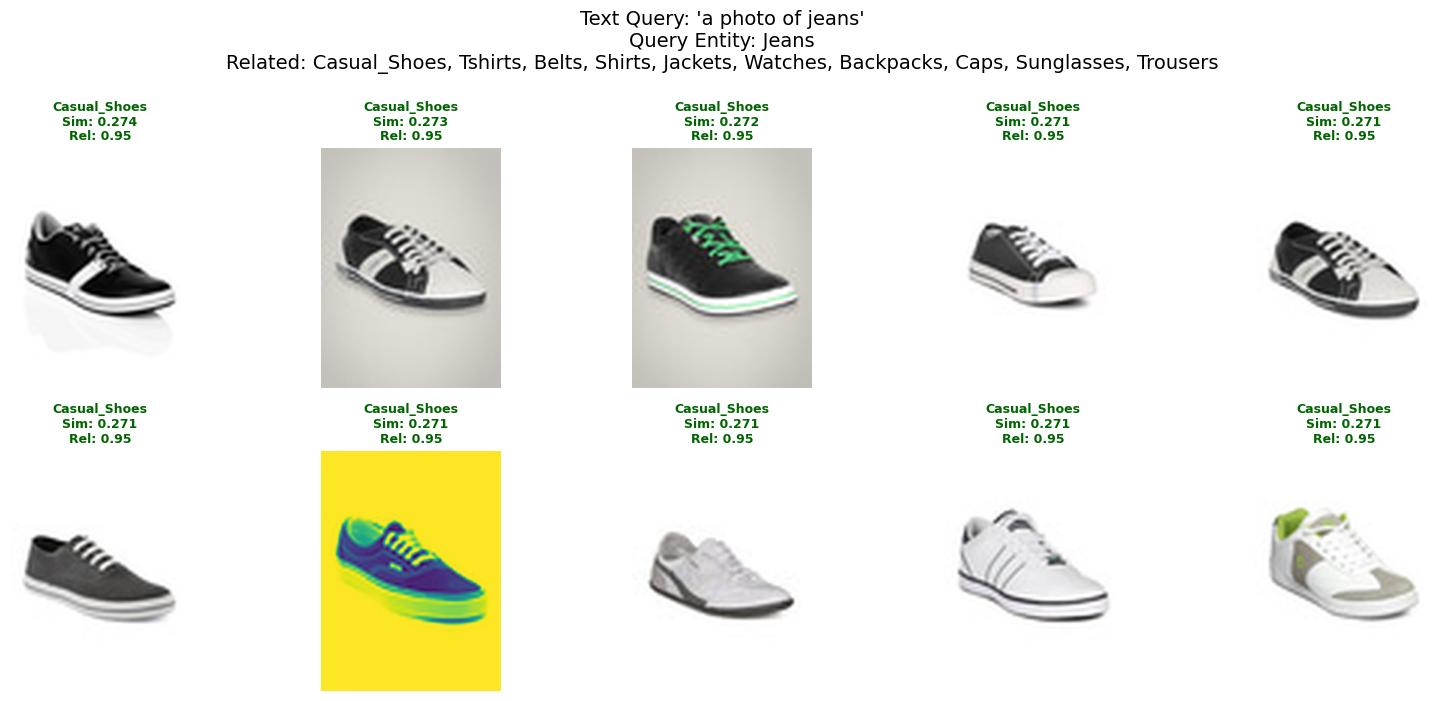

In [18]:
# Example with text query for fashion
query_text = "a photo of jeans"

print(f"Querying with text: '{query_text}'\n")

# Get recommendations using knowledge graph
kg_results = kg_based_recommendation(
    query_input=query_text,
    input_type='text',
    top_k=10,
    use_semantic_expansion=True
)

print(f"\nTotal recommendations: {len(kg_results['recommendations'])}")
print("\nTop 5 recommendations (Cosine Similarity):")
for i, result in enumerate(kg_results['recommendations'][:5], 1):
    entity = result.get('matched_label', 'unknown')
    sim = result.get('weighted_similarity', result.get('similarity', 0))
    rel_strength = result.get('relationship_strength', 0)
    is_primary = result.get('is_primary', False)
    marker = "⭐" if is_primary else "  "
    print(f"{marker} {i}. {entity} - Similarity: {sim:.4f} (Rel: {rel_strength:.2f})")

# Display the results
display_kg_recommendations(kg_results, query_info=f"Text Query: '{query_text}'",
                          upscale=UPSCALE_IMAGES, min_display_size=MIN_DISPLAY_SIZE)

In [19]:
# Explore relationships in the fashion knowledge graph
entity_to_explore = "Tshirts"

print(f"Exploring entity: {entity_to_explore}\n")

if entity_to_explore in knowledge_graph['entities']:
    entity_info = knowledge_graph['entities'][entity_to_explore]
    
    print("Entity Information:")
    print(f"   Entity Name: {entity_to_explore}")
    
    print(f"\n🔗 Related Entities with Relationship Strengths (Cosine Similarity):")
    related = get_related_entities(entity_to_explore, max_related=10)
    for rel_entity, strength in related:
        # Color-code by strength
        if strength >= 0.8:
            indicator = "Very Strong"
        elif strength >= 0.6:
            indicator = "Strong"
        elif strength >= 0.4:
            indicator = "Moderate"
        else:
            indicator = "Weak"
        print(f"   - {rel_entity}: {strength:.2f} ({indicator})")
    
    # Show total number of relationships
    print(f"\nTotal relationships: {len(related)}")
else:
    print(f"Entity '{entity_to_explore}' not found in knowledge graph")

Exploring entity: Tshirts

Entity Information:
   Entity Name: Tshirts

🔗 Related Entities with Relationship Strengths (Cosine Similarity):
   - Jeans: 0.95 (Very Strong)
   - Casual_Shoes: 0.90 (Very Strong)
   - Shorts: 0.85 (Very Strong)
   - Track_Pants: 0.80 (Very Strong)
   - Belts: 0.70 (Strong)
   - Watches: 0.65 (Strong)
   - Caps: 0.60 (Strong)
   - Backpacks: 0.55 (Moderate)
   - Jackets: 0.50 (Moderate)
   - Sunglasses: 0.45 (Moderate)

Total relationships: 10


In [20]:
# Compare standard search vs knowledge graph-enhanced search for fashion
comparison_query = "shirts"

print(f"Comparing search methods for: '{comparison_query}'\n")

# Standard text search (Cosine Similarity)
print("=" * 60)
print("STANDARD SEARCH (Text-only with Cosine Similarity)")
print("=" * 60)
standard_embedding = get_text_embedding(f"a photo of a {comparison_query}")
standard_results = search_similar_images(standard_embedding, top_k=5)

print(f"\nTop 5 results:")
for i, result in enumerate(standard_results, 1):
    path_entity = find_entity_from_path(result['path'])
    print(f"{i}. {path_entity} - Similarity: {result['similarity']:.4f}")

# Knowledge graph-enhanced search (with relationship strength weighting)
print("\n" + "=" * 60)
print("KNOWLEDGE GRAPH-ENHANCED SEARCH (with Relationship Weighting)")
print("=" * 60)
kg_results = kg_based_recommendation(
    query_input=f"a photo of a {comparison_query}",
    input_type='text',
    top_k=10,
    use_semantic_expansion=True
)

print(f"\nTop 5 results:")
for i, result in enumerate(kg_results['recommendations'][:5], 1):
    entity = result.get('matched_label', 'unknown')
    sim = result.get('weighted_similarity', result.get('similarity', 0))
    rel_strength = result.get('relationship_strength', 0)
    is_primary = result.get('is_primary', False)
    marker = "⭐" if is_primary else "🔗"
    print(f"{marker} {i}. {entity} - Weighted Sim: {sim:.4f} (Rel: {rel_strength:.2f})")

print("\nKG-enhanced search provides:")
print("   ✓ Semantic expansion using related fashion categories")
print("   ✓ Context from style and outfit relationships") 
print("   ✓ Diverse recommendations across complementary items")
print("   ✓ Weighted similarity scores based on relationship strength")
print("   ✓ All searches use cosine similarity as the base metric")

Comparing search methods for: 'shirts'

STANDARD SEARCH (Text-only with Cosine Similarity)

Top 5 results:
1. Shirts - Similarity: 0.2879
2. Tops - Similarity: 0.2874
3. Shirts - Similarity: 0.2842
4. Shirts - Similarity: 0.2836
5. Shirts - Similarity: 0.2820

KNOWLEDGE GRAPH-ENHANCED SEARCH (with Relationship Weighting)
Query entity: Shirts
Related entities with strengths:
   - Trousers: 0.95
   - Formal_Shoes: 0.90
   - Belts: 0.85
   - Watches: 0.80
   - Ties: 0.75
   - Blazers: 0.70
   - Jeans: 0.65
   - Sunglasses: 0.50
   - Casual_Shoes: 0.45
   - Tshirts: 0.30
✓ Found 10 recommendations from related classes

Top 5 results:
🔗 1. Trousers - Weighted Sim: 0.2778 (Rel: 0.95)
🔗 2. Trousers - Weighted Sim: 0.2754 (Rel: 0.95)
🔗 3. Trousers - Weighted Sim: 0.2751 (Rel: 0.95)
🔗 4. Formal_Shoes - Weighted Sim: 0.2749 (Rel: 0.90)
🔗 5. Formal_Shoes - Weighted Sim: 0.2736 (Rel: 0.90)

KG-enhanced search provides:
   ✓ Semantic expansion using related fashion categories
   ✓ Context from styl

In [21]:
# Get recommendations for multiple related entities
entities_of_interest = ["Tshirts", "Jeans", "Casual_Shoes"]

print(f"Getting recommendations for multiple entities: {entities_of_interest}\n")

all_entity_results = {}

for entity in entities_of_interest:
    print(f"\n{'='*60}")
    print(f"Processing: {entity}")
    print(f"{'='*60}")
    
    # Create text query for the entity
    text_query = f"a photo of a {entity}"
    
    # Get KG-based recommendations
    kg_results = kg_based_recommendation(
        query_input=text_query,
        input_type='text',
        top_k=5,
        use_semantic_expansion=False  # Disable expansion for focused results
    )
    
    all_entity_results[entity] = kg_results
    
    # Show summary
    print(f"Related entities: {kg_results['related_entities']}")
    print(f"Total recommendations: {len(kg_results['recommendations'])}")

# Show entity relationship matrix
print(f"\n\n{'='*60}")
print("ENTITY RELATIONSHIP MATRIX")
print(f"{'='*60}\n")

# Get all relationships
print("Entity relationships:")
for entity in entities_of_interest:
    if entity in knowledge_graph['entities']:
        related = knowledge_graph['entities'][entity]['related_entities']
        print(f"\n{entity.upper()}:")
        for rel_entity, strength in sorted(related.items(), key=lambda x: -x[1]):
            if rel_entity in entities_of_interest:
                print(f"  → {rel_entity}: {strength:.2f}")

print("\nHigher strength scores indicate stronger relationships in the knowledge graph")

Getting recommendations for multiple entities: ['Tshirts', 'Jeans', 'Casual_Shoes']


Processing: Tshirts
Query entity: Tshirts
Related entities with strengths:
   - Jeans: 0.95
   - Casual_Shoes: 0.90
   - Shorts: 0.85
   - Track_Pants: 0.80
   - Belts: 0.70
   - Watches: 0.65
   - Caps: 0.60
   - Backpacks: 0.55
   - Jackets: 0.50
   - Sunglasses: 0.45
✓ Found 5 recommendations from related classes
Related entities: ['Jeans', 'Casual_Shoes', 'Shorts', 'Track_Pants', 'Belts', 'Watches', 'Caps', 'Backpacks', 'Jackets', 'Sunglasses']
Total recommendations: 5

Processing: Jeans
Query entity: Jeans
Related entities with strengths:
   - Casual_Shoes: 0.95
   - Tshirts: 0.90
   - Belts: 0.85
   - Shirts: 0.80
   - Jackets: 0.75
   - Watches: 0.65
   - Backpacks: 0.60
   - Caps: 0.55
   - Sunglasses: 0.50
   - Trousers: 0.25
✓ Found 5 recommendations from related classes
Related entities: ['Jeans', 'Casual_Shoes', 'Shorts', 'Track_Pants', 'Belts', 'Watches', 'Caps', 'Backpacks', 'Jackets', '